# 循环神经网络
本节介绍循环神经网络，下图展示了如何基于循环神经网络实现语言模型。我们的目的是基于当前的输入与过去的输入序列，预测序列的下一个字符。循环神经网络引入一个隐藏变量$H$，用$H_{t}$表示$H$在时间步$t$的值。$H_{t}$的计算基于$X_{t}$和$H_{t-1}$，可以认为$H_{t}$记录了到当前字符为止的序列信息，利用$H_{t}$对序列的下一个字符进行预测。
![Image Name](./imgs/rnn1-1.png)
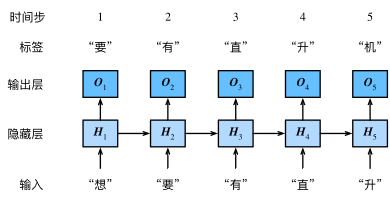

## 循环神经网络的构造

我们先看循环神经网络的具体构造。假设$\boldsymbol{X}_t \in \mathbb{R}^{n \times d}$是时间步$t$的小批量输入，$\boldsymbol{H}_t  \in \mathbb{R}^{n \times h}$是该时间步的隐藏变量，则：


$$
\boldsymbol{H}_t = \phi(\boldsymbol{X}_t \boldsymbol{W}_{xh} + \boldsymbol{H}_{t-1} \boldsymbol{W}_{hh}  + \boldsymbol{b}_h).
$$


其中，$\boldsymbol{W}_{xh} \in \mathbb{R}^{d \times h}$，$\boldsymbol{W}_{hh} \in \mathbb{R}^{h \times h}$，$\boldsymbol{b}_{h} \in \mathbb{R}^{1 \times h}$，$\phi$函数是非线性激活函数。由于引入了$\boldsymbol{H}_{t-1} \boldsymbol{W}_{hh}$，$H_{t}$能够捕捉截至当前时间步的序列的历史信息，就像是神经网络当前时间步的状态或记忆一样。由于$H_{t}$的计算基于$H_{t-1}$，上式的计算是循环的，使用循环计算的网络即循环神经网络（recurrent neural network）。

在时间步$t$，输出层的输出为：


$$
\boldsymbol{O}_t = \boldsymbol{H}_t \boldsymbol{W}_{hq} + \boldsymbol{b}_q.
$$


其中$\boldsymbol{W}_{hq} \in \mathbb{R}^{h \times q}$，$\boldsymbol{b}_q \in \mathbb{R}^{1 \times q}$。


## 从零开始实现循环神经网络

我们先尝试从零开始实现一个基于字符级循环神经网络的语言模型，这里我们使用周杰伦的歌词作为语料，首先我们读入数据：

In [2]:
def load_data_jay_lyrics():
    """加载周杰伦歌词数据集"""
    with zipfile.ZipFile('../dataset/jaychou_lyrics.txt.zip') as zin:
        with zin.open('jaychou_lyrics.txt') as f:
            corpus_chars = f.read().decode('utf-8')
    corpus_chars = corpus_chars.replace('\n', ' ').replace('\r', ' ')
    corpus_chars = corpus_chars[0:10000]
    idx_to_char = list(set(corpus_chars))
    char_to_idx = dict([(char, i) for i, char in enumerate(idx_to_char)])
    vocab_size = len(char_to_idx)
    corpus_indices = [char_to_idx[char] for char in corpus_chars]
    return corpus_indices, char_to_idx, idx_to_char, vocab_size

In [4]:
import torch
import torch.nn as nn
import time
import math
import sys
import zipfile
sys.path.append('..')
import d2lzh_pytorch as d2l
(corpus_indices, char_to_idx, idx_to_char, vocab_size) = load_data_jay_lyrics()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### one-hot向量

我们需要将字符表示成向量，这里采用one-hot向量。假设词典大小是$N$，每次字符对应一个从$0$到$N-1$的唯一的索引，则该字符的向量是一个长度为$N$的向量，若字符的索引是$i$，则该向量的第$i$个位置为$1$，其他位置为$0$。下面分别展示了索引为0和2的one-hot向量，向量长度等于词典大小。

In [5]:
def one_hot(x, n_class, dtype=torch.float32):
    result = torch.zeros(x.shape[0], n_class, dtype=dtype, device=x.device)  # shape: (n, n_class)
    result.scatter_(1, x.long().view(-1, 1), 1)  # result[i, x[i, 0]] = 1
    return result
    
x = torch.tensor([0, 2])
x_one_hot = one_hot(x, vocab_size)
print(x_one_hot)
print(x_one_hot.shape)
print(x_one_hot.sum(axis=1))

tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.]])
torch.Size([2, 1027])
tensor([1., 1.])


我们每次采样的小批量的形状是（批量大小, 时间步数）。下面的函数将这样的小批量变换成数个形状为（批量大小, 词典大小）的矩阵，矩阵个数等于时间步数。也就是说，时间步$t$的输入为$\boldsymbol{X}_t \in \mathbb{R}^{n \times d}$，其中$n$为批量大小，$d$为词向量大小，即one-hot向量长度（词典大小）。

In [6]:
def to_onehot(X, n_class):
    return [one_hot(X[:, i], n_class) for i in range(X.shape[1])]

X = torch.arange(10).view(2, 5)
print(X)
inputs = to_onehot(X, vocab_size)
print(len(inputs), inputs[0].shape)
print(inputs)

tensor([[0, 1, 2, 3, 4],
        [5, 6, 7, 8, 9]])
5 torch.Size([2, 1027])
[tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]), tensor([[0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]), tensor([[0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]), tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]), tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])]


### 初始化模型参数


In [7]:
num_inputs, num_hiddens, num_outputs = vocab_size, 256, vocab_size
# num_inputs: d
# num_hiddens: h, 隐藏单元的个数是超参数
# num_outputs: q

def get_params():
    def _one(shape):
        param = torch.zeros(shape, device=device, dtype=torch.float32)
        nn.init.normal_(param, 0, 0.01)
        return torch.nn.Parameter(param)

    # 隐藏层参数
    W_xh = _one((num_inputs, num_hiddens))
    W_hh = _one((num_hiddens, num_hiddens))
    b_h = torch.nn.Parameter(torch.zeros(num_hiddens, device=device))
    # 输出层参数
    W_hq = _one((num_hiddens, num_outputs))
    b_q = torch.nn.Parameter(torch.zeros(num_outputs, device=device))
    return (W_xh, W_hh, b_h, W_hq, b_q)

### 定义模型

函数`rnn`用循环的方式依次完成循环神经网络每个时间步的计算。


In [8]:
def rnn(inputs, state, params):
    # inputs和outputs皆为num_steps个形状为(batch_size, vocab_size)的矩阵
    W_xh, W_hh, b_h, W_hq, b_q = params
    H, = state
    outputs = []
    for X in inputs:
        H = torch.tanh(torch.matmul(X, W_xh) + torch.matmul(H, W_hh) + b_h)
        Y = torch.matmul(H, W_hq) + b_q
        outputs.append(Y)
    return outputs, (H,)

函数init_rnn_state初始化隐藏变量，这里的返回值是一个元组。


In [9]:
def init_rnn_state(batch_size, num_hiddens, device):
    return (torch.zeros((batch_size, num_hiddens), device=device), )

做个简单的测试来观察输出结果的个数（时间步数），以及第一个时间步的输出层输出的形状和隐藏状态的形状。

In [10]:
print(X.shape)
print(num_hiddens)
print(vocab_size)
state = init_rnn_state(X.shape[0], num_hiddens, device)
inputs = to_onehot(X.to(device), vocab_size)
params = get_params()
outputs, state_new = rnn(inputs, state, params)
print(len(inputs), inputs[0].shape)
print(len(outputs), outputs[0].shape)
print(len(state), state[0].shape)
print(len(state_new), state_new[0].shape)

print('state', state)
print('inputs', inputs)
print('outputs', outputs)
print('state_new', state_new)

torch.Size([2, 5])
256
1027
5 torch.Size([2, 1027])
5 torch.Size([2, 1027])
1 torch.Size([2, 256])
1 torch.Size([2, 256])
state (tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0.

### 裁剪梯度

循环神经网络中较容易出现梯度衰减或梯度爆炸，这会导致网络几乎无法训练。裁剪梯度（clip gradient）是一种应对梯度爆炸的方法。假设我们把所有模型参数的梯度拼接成一个向量 $\boldsymbol{g}$，并设裁剪的阈值是$\theta$。裁剪后的梯度


$$
 \min\left(\frac{\theta}{\|\boldsymbol{g}\|}, 1\right)\boldsymbol{g}
$$


的$L_2$范数不超过$\theta$。


In [11]:
def grad_clipping(params, theta, device):
    norm = torch.tensor([0.0], device=device)
    for param in params:
        norm += (param.grad.data ** 2).sum()
    norm = norm.sqrt().item()  # 获得数值
    if norm > theta:
        for param in params:
            param.grad.data *= (theta / norm)

### 定义预测函数

以下函数基于前缀`prefix`（含有数个字符的字符串）来预测接下来的`num_chars`个字符。这个函数稍显复杂，其中我们将循环神经单元`rnn`设置成了函数参数，这样在后面小节介绍其他循环神经网络时能重复使用这个函数。


In [12]:
def predict_rnn(prefix, num_chars, rnn, params, init_rnn_state,
                num_hiddens, vocab_size, device, idx_to_char, char_to_idx):
    state = init_rnn_state(1, num_hiddens, device)
    output = [char_to_idx[prefix[0]]]   # output记录prefix加上预测的num_chars个字符
    for t in range(num_chars + len(prefix) - 1):
        # 将上一时间步的输出作为当前时间步的输入
        X = to_onehot(torch.tensor([[output[-1]]], device=device), vocab_size)
        print('output', output)
        # 计算输出和更新隐藏状态
        (Y, state) = rnn(X, state, params)
        print('Y', Y)
        # 下一个时间步的输入是prefix里的字符或者当前的最佳预测字符
        if t < len(prefix) - 1:
            output.append(char_to_idx[prefix[t + 1]]) # 非预测值
        else:
            output.append(Y[0].argmax(dim=1).item())
    print('Y shape', Y[0].shape)
    return ''.join([idx_to_char[i] for i in output])

我们先测试一下`predict_rnn`函数。我们将根据前缀“分开”创作长度为10个字符（不考虑前缀长度）的一段歌词。因为模型参数为随机值，所以预测结果也是随机的。

In [13]:
predict_rnn('分开', 10, rnn, params, init_rnn_state, num_hiddens, vocab_size,
            device, idx_to_char, char_to_idx)

output [871]
Y [tensor([[-2.7264e-05, -3.1853e-03, -1.4429e-03,  ...,  4.4702e-04,
         -7.5656e-05,  1.0955e-03]], grad_fn=<AddBackward0>)]
output [871, 160]
Y [tensor([[-0.0004, -0.0016,  0.0017,  ..., -0.0027, -0.0003,  0.0010]],
       grad_fn=<AddBackward0>)]
output [871, 160, 904]
Y [tensor([[-0.0006, -0.0002, -0.0003,  ...,  0.0009, -0.0005, -0.0021]],
       grad_fn=<AddBackward0>)]
output [871, 160, 904, 384]
Y [tensor([[-7.5955e-05,  1.1173e-03,  2.6051e-03,  ...,  8.5047e-04,
          7.0426e-04,  2.6646e-04]], grad_fn=<AddBackward0>)]
output [871, 160, 904, 384, 540]
Y [tensor([[ 0.0014, -0.0033, -0.0022,  ..., -0.0002, -0.0009,  0.0004]],
       grad_fn=<AddBackward0>)]
output [871, 160, 904, 384, 540, 193]
Y [tensor([[-0.0003, -0.0023,  0.0004,  ..., -0.0007, -0.0016, -0.0008]],
       grad_fn=<AddBackward0>)]
output [871, 160, 904, 384, 540, 193, 365]
Y [tensor([[ 5.7915e-06,  4.7759e-04, -7.5693e-05,  ..., -7.5043e-04,
         -1.1503e-03,  1.4640e-03]], grad_fn=<

'分开客缘钟朵丛灰敌袭打词'

### 困惑度

我们通常使用困惑度（perplexity）来评价语言模型的好坏。回忆一下[“softmax回归”](./softmax-regression.ipynb)一节中交叉熵损失函数的定义。困惑度是对交叉熵损失函数做指数运算后得到的值。特别地，

* 最佳情况下，模型总是把标签类别的概率预测为1，此时困惑度为1；
* 最坏情况下，模型总是把标签类别的概率预测为0，此时困惑度为正无穷；
* 基线情况下，模型总是预测所有类别的概率都相同，此时困惑度为类别个数。

显然，任何一个有效模型的困惑度必须小于类别个数。在本例中，困惑度必须小于词典大小`vocab_size`。

### 定义模型训练函数

跟之前章节的模型训练函数相比，这里的模型训练函数有以下几点不同：

1. 使用困惑度评价模型。
2. 在迭代模型参数前裁剪梯度。
3. 对时序数据采用不同采样方法将导致隐藏状态初始化的不同。

In [14]:
a = torch.tensor([1,2,3.], requires_grad=True)
print(a.grad)
out = a.sigmoid()
out.sum().backward()
print(a.grad)

None
tensor([0.1966, 0.1050, 0.0452])


In [15]:
a = torch.tensor([1, 2, 3.], requires_grad=True)
print(a.grad)
out = a.sigmoid()
print(out)
c = out.detach()
print(c)
out = a.sigmoid()
out.sum().backward()
print(a.grad)
# 可见c,out之间的区别是c是没有梯度的，out是有梯度的

None
tensor([0.7311, 0.8808, 0.9526], grad_fn=<SigmoidBackward>)
tensor([0.7311, 0.8808, 0.9526])
tensor([0.1966, 0.1050, 0.0452])


In [16]:
a = torch.tensor([1, 2, 3.], requires_grad=True)
print(a.grad)
out = a.sigmoid()
print(out)

#添加detach(),c的requires_grad为False
c = out.detach()
print(c)

#使用新生成的Variable进行反向传播
c.sum().backward()
print(a.grad)
# 如果这里使用的是c进行sum()操作并进行backward()，则会报错：

None
tensor([0.7311, 0.8808, 0.9526], grad_fn=<SigmoidBackward>)
tensor([0.7311, 0.8808, 0.9526])


RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

In [30]:
a = torch.tensor([1, 2, 3.], requires_grad=True)
print(a.grad)
out = a.sigmoid()
print(out)

#添加detach(),c的requires_grad为False
c = out.detach()
print(c)
c.zero_() #使用in place函数对其进行修改

#会发现c的修改同时会影响out的值
print(c)
print(out)

#这时候对c进行更改，所以会影响backward()，这时候就不能进行backward()，会报错
out.sum().backward()
print(a.grad)
# 如果此时对c进行了更改，这个更改会被autograd追踪，在对out.sum()进行backward()时也会报错，
# 因为此时的值进行backward()得到的梯度是错误的：

None
tensor([0.7311, 0.8808, 0.9526], grad_fn=<SigmoidBackward>)
tensor([0.7311, 0.8808, 0.9526])
tensor([0., 0., 0.])
tensor([0., 0., 0.], grad_fn=<SigmoidBackward>)


RuntimeError: one of the variables needed for gradient computation has been modified by an inplace operation: [torch.FloatTensor [3]], which is output 0 of SigmoidBackward, is at version 1; expected version 0 instead. Hint: enable anomaly detection to find the operation that failed to compute its gradient, with torch.autograd.set_detect_anomaly(True).

In [31]:
a = torch.tensor([1, 2, 3.], requires_grad=True)
print(a.grad)
out = a.sigmoid()
print(out)


c = out.data
print(c)
c.zero_() #使用in place函数对其进行修改

#会发现c的修改同时也会影响out的值
print(c)
print(out)

#这里的不同在于.data的修改不会被autograd追踪，这样当进行backward()时它不会报错，回得到一个错误的backward值
out.sum().backward()
print(a.grad)

None
tensor([0.7311, 0.8808, 0.9526], grad_fn=<SigmoidBackward>)
tensor([0.7311, 0.8808, 0.9526])
tensor([0., 0., 0.])
tensor([0., 0., 0.], grad_fn=<SigmoidBackward>)
tensor([0., 0., 0.])


**In-place 正确性检查**

所有的Variable都会记录用在他们身上的 in-place operations。如果pytorch检测到variable在一个Function中已经被保存用来backward，但是之后它又被in-place operations修改。当这种情况发生时，在backward的时候，pytorch就会报错。这种机制保证了，如果你用了in-place operations，但是在backward过程中没有报错，那么梯度的计算就是正确的。

In [32]:
a = torch.tensor([1, 2, 3.], requires_grad=True)
print(a.grad)
out = a.sigmoid().sum() #但是如果sum写在这里，而不是写在backward()前，得到的结果是正确的
print(out)


c = out.data
print(c)
c.zero_() #使用in place函数对其进行修改

#会发现c的修改同时也会影响out的值
print(c)
print(out)

#没有写在这里
out.backward()
print(a.grad)

None
tensor(2.5644, grad_fn=<SumBackward0>)
tensor(2.5644)
tensor(0.)
tensor(0., grad_fn=<SumBackward0>)
tensor([0.1966, 0.1050, 0.0452])


In [33]:
def train_and_predict_rnn(rnn, get_params, init_rnn_state, num_hiddens,
                          vocab_size, device, corpus_indices, idx_to_char,
                          char_to_idx, is_random_iter, num_epochs, num_steps,
                          lr, clipping_theta, batch_size, pred_period,
                          pred_len, prefixes):
    if is_random_iter:
        data_iter_fn = d2l.data_iter_random
    else:
        data_iter_fn = d2l.data_iter_consecutive
    params = get_params()
    loss = nn.CrossEntropyLoss()

    for epoch in range(num_epochs):
        if not is_random_iter:  # 如使用相邻采样，在epoch开始时初始化隐藏状态
            state = init_rnn_state(batch_size, num_hiddens, device)
        l_sum, n, start = 0.0, 0, time.time()
        data_iter = data_iter_fn(corpus_indices, batch_size, num_steps, device)
        for X, Y in data_iter:
            if is_random_iter:  # 如使用随机采样，在每个小批量更新前初始化隐藏状态
                state = init_rnn_state(batch_size, num_hiddens, device)
            else:  # 否则需要使用detach函数从计算图分离隐藏状态
                for s in state:
                    s.detach_() # detach_()是对本身的更改，detach()则是生成了一个新的variable
            # inputs是num_steps个形状为(batch_size, vocab_size)的矩阵
            inputs = to_onehot(X, vocab_size)
            # outputs有num_steps个形状为(batch_size, vocab_size)的矩阵
            (outputs, state) = rnn(inputs, state, params)
            # 拼接之后形状为(num_steps * batch_size, vocab_size)
            outputs = torch.cat(outputs, dim=0)
            # Y的形状是(batch_size, num_steps)，转置后再变成形状为
            # (num_steps * batch_size,)的向量，这样跟输出的行一一对应
            y = torch.flatten(Y.T)
            # 使用交叉熵损失计算平均分类误差
            l = loss(outputs, y.long())
            
            # 梯度清0
            if params[0].grad is not None:
                for param in params:
                    param.grad.data.zero_()
            l.backward()
            grad_clipping(params, clipping_theta, device)  # 裁剪梯度
            d2l.sgd(params, lr, 1)  # 因为误差已经取过均值，梯度不用再做平均
            l_sum += l.item() * y.shape[0]
            n += y.shape[0]

        if (epoch + 1) % pred_period == 0:
            print('epoch %d, perplexity %f, time %.2f sec' % (
                epoch + 1, math.exp(l_sum / n), time.time() - start))
            for prefix in prefixes:
                print(' -', predict_rnn(prefix, pred_len, rnn, params, init_rnn_state,
                    num_hiddens, vocab_size, device, idx_to_char, char_to_idx))

### 训练模型并创作歌词

现在我们可以训练模型了。首先，设置模型超参数。我们将根据前缀“分开”和“不分开”分别创作长度为50个字符（不考虑前缀长度）的一段歌词。我们每过50个迭代周期便根据当前训练的模型创作一段歌词。

In [34]:
num_epochs, num_steps, batch_size, lr, clipping_theta = 250, 35, 32, 1e2, 1e-2
pred_period, pred_len, prefixes = 50, 50, ['分开', '不分开']

下面采用随机采样训练模型并创作歌词。

In [35]:
train_and_predict_rnn(rnn, get_params, init_rnn_state, num_hiddens,
                      vocab_size, device, corpus_indices, idx_to_char,
                      char_to_idx, True, num_epochs, num_steps, lr,
                      clipping_theta, batch_size, pred_period, pred_len,
                      prefixes)

epoch 50, perplexity 68.082417, time 3.05 sec
output [922]
output [922, 1001]
output [922, 1001, 297]
output [922, 1001, 297, 491]
output [922, 1001, 297, 491, 55]
output [922, 1001, 297, 491, 55, 983]
output [922, 1001, 297, 491, 55, 983, 563]
output [922, 1001, 297, 491, 55, 983, 563, 297]
output [922, 1001, 297, 491, 55, 983, 563, 297, 575]
output [922, 1001, 297, 491, 55, 983, 563, 297, 575, 492]
output [922, 1001, 297, 491, 55, 983, 563, 297, 575, 492, 491]
output [922, 1001, 297, 491, 55, 983, 563, 297, 575, 492, 491, 297]
output [922, 1001, 297, 491, 55, 983, 563, 297, 575, 492, 491, 297, 344]
output [922, 1001, 297, 491, 55, 983, 563, 297, 575, 492, 491, 297, 344, 575]
output [922, 1001, 297, 491, 55, 983, 563, 297, 575, 492, 491, 297, 344, 575, 491]
output [922, 1001, 297, 491, 55, 983, 563, 297, 575, 492, 491, 297, 344, 575, 491, 297]
output [922, 1001, 297, 491, 55, 983, 563, 297, 575, 492, 491, 297, 344, 575, 491, 297, 575]
output [922, 1001, 297, 491, 55, 983, 563, 297, 57

接下来采用相邻采样训练模型并创作歌词。

In [36]:
train_and_predict_rnn(rnn, get_params, init_rnn_state, num_hiddens,
                      vocab_size, device, corpus_indices, idx_to_char,
                      char_to_idx, False, num_epochs, num_steps, lr,
                      clipping_theta, batch_size, pred_period, pred_len,
                      prefixes)

epoch 50, perplexity 60.261396, time 3.12 sec
output [922]
output [922, 1001]
output [922, 1001, 297]
output [922, 1001, 297, 491]
output [922, 1001, 297, 491, 201]
output [922, 1001, 297, 491, 201, 983]
output [922, 1001, 297, 491, 201, 983, 18]
output [922, 1001, 297, 491, 201, 983, 18, 55]
output [922, 1001, 297, 491, 201, 983, 18, 55, 297]
output [922, 1001, 297, 491, 201, 983, 18, 55, 297, 491]
output [922, 1001, 297, 491, 201, 983, 18, 55, 297, 491, 55]
output [922, 1001, 297, 491, 201, 983, 18, 55, 297, 491, 55, 983]
output [922, 1001, 297, 491, 201, 983, 18, 55, 297, 491, 55, 983, 563]
output [922, 1001, 297, 491, 201, 983, 18, 55, 297, 491, 55, 983, 563, 55]
output [922, 1001, 297, 491, 201, 983, 18, 55, 297, 491, 55, 983, 563, 55, 297]
output [922, 1001, 297, 491, 201, 983, 18, 55, 297, 491, 55, 983, 563, 55, 297, 491]
output [922, 1001, 297, 491, 201, 983, 18, 55, 297, 491, 55, 983, 563, 55, 297, 491, 55]
output [922, 1001, 297, 491, 201, 983, 18, 55, 297, 491, 55, 983, 563,

## 循环神经网络的简介实现

### 定义模型

我们使用Pytorch中的`nn.RNN`来构造循环神经网络。在本节中，我们主要关注`nn.RNN`的以下几个构造函数参数：

* `input_size` - The number of expected features in the input x
* `hidden_size` – The number of features in the hidden state h
* `nonlinearity` – The non-linearity to use. Can be either 'tanh' or 'relu'. Default: 'tanh'
* `batch_first` – If True, then the input and output tensors are provided as (batch_size, num_steps, input_size). Default: False

这里的`batch_first`决定了输入的形状，我们使用默认的参数`False`，对应的输入形状是 (num_steps, batch_size, input_size)。

`forward`函数的参数为：

* `input` of shape (num_steps, batch_size, input_size): tensor containing the features of the input sequence. 
* `h_0` of shape (num_layers * num_directions, batch_size, hidden_size): tensor containing the initial hidden state for each element in the batch. Defaults to zero if not provided. If the RNN is bidirectional, num_directions should be 2, else it should be 1.

`forward`函数的返回值是：

* `output` of shape (num_steps, batch_size, num_directions * hidden_size): tensor containing the output features (h_t) from the last layer of the RNN, for each t.
* `h_n` of shape (num_layers * num_directions, batch_size, hidden_size): tensor containing the hidden state for t = num_steps.

现在我们构造一个`nn.RNN`实例，并用一个简单的例子来看一下输出的形状。

In [15]:
rnn_layer = nn.RNN(input_size=vocab_size, hidden_size=num_hiddens)
num_steps, batch_size = 35, 2
X = torch.rand(num_steps, batch_size, vocab_size)
state = None
Y, state_new = rnn_layer(X, state)
print(Y.shape, state_new.shape)

torch.Size([35, 2, 256]) torch.Size([1, 2, 256])


我们定义一个完整的基于循环神经网络的语言模型。

In [16]:
class RNNModel(nn.Module):
    def __init__(self, rnn_layer, vocab_size):
        super(RNNModel, self).__init__()
        self.rnn = rnn_layer
        self.hidden_size = rnn_layer.hidden_size * (2 if rnn_layer.bidirectional else 1) 
        self.vocab_size = vocab_size
        self.dense = nn.Linear(self.hidden_size, vocab_size)

    def forward(self, inputs, state):
        # inputs.shape: (batch_size, num_steps)
        X = to_onehot(inputs, vocab_size)
        X = torch.stack(X)  # X.shape: (num_steps, batch_size, vocab_size)
        hiddens, state = self.rnn(X, state)
        hiddens = hiddens.view(-1, hiddens.shape[-1])  # hiddens.shape: (num_steps * batch_size, hidden_size)
        output = self.dense(hiddens)
        return output, state

类似的，我们需要实现一个预测函数，与前面的区别在于前向计算和初始化隐藏状态。

In [17]:
def predict_rnn_pytorch(prefix, num_chars, model, vocab_size, device, idx_to_char,
                      char_to_idx):
    state = None
    output = [char_to_idx[prefix[0]]]  # output记录prefix加上预测的num_chars个字符
    for t in range(num_chars + len(prefix) - 1):
        X = torch.tensor([output[-1]], device=device).view(1, 1)
        (Y, state) = model(X, state)  # 前向计算不需要传入模型参数
        if t < len(prefix) - 1:
            output.append(char_to_idx[prefix[t + 1]])
        else:
            output.append(Y.argmax(dim=1).item())
    return ''.join([idx_to_char[i] for i in output])

使用权重为随机值的模型来预测一次。

In [18]:
model = RNNModel(rnn_layer, vocab_size).to(device)
predict_rnn_pytorch('分开', 10, model, vocab_size, device, idx_to_char, char_to_idx)

'分开胸呵以轮轮轮轮轮轮轮'

接下来实现训练函数，这里只使用了相邻采样。

In [19]:
def train_and_predict_rnn_pytorch(model, num_hiddens, vocab_size, device,
                                corpus_indices, idx_to_char, char_to_idx,
                                num_epochs, num_steps, lr, clipping_theta,
                                batch_size, pred_period, pred_len, prefixes):
    loss = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    model.to(device)
    for epoch in range(num_epochs):
        l_sum, n, start = 0.0, 0, time.time()
        data_iter = d2l.data_iter_consecutive(corpus_indices, batch_size, num_steps, device) # 相邻采样
        state = None
        for X, Y in data_iter:
            if state is not None:
                # 使用detach函数从计算图分离隐藏状态
                if isinstance (state, tuple): # LSTM, state:(h, c)  
                    state[0].detach_()
                    state[1].detach_()
                else: 
                    state.detach_()
            (output, state) = model(X, state) # output.shape: (num_steps * batch_size, vocab_size)
            y = torch.flatten(Y.T)
            l = loss(output, y.long())
            
            optimizer.zero_grad()
            l.backward()
            grad_clipping(model.parameters(), clipping_theta, device)
            optimizer.step()
            l_sum += l.item() * y.shape[0]
            n += y.shape[0]
        

        if (epoch + 1) % pred_period == 0:
            print('epoch %d, perplexity %f, time %.2f sec' % (
                epoch + 1, math.exp(l_sum / n), time.time() - start))
            for prefix in prefixes:
                print(' -', predict_rnn_pytorch(
                    prefix, pred_len, model, vocab_size, device, idx_to_char,
                    char_to_idx))

训练模型。

In [20]:
num_epochs, batch_size, lr, clipping_theta = 250, 32, 1e-3, 1e-2
pred_period, pred_len, prefixes = 50, 50, ['分开', '不分开']
train_and_predict_rnn_pytorch(model, num_hiddens, vocab_size, device,
                            corpus_indices, idx_to_char, char_to_idx,
                            num_epochs, num_steps, lr, clipping_theta,
                            batch_size, pred_period, pred_len, prefixes)

epoch 50, perplexity 9.405654, time 0.52 sec
 - 分开始一起 三步四步望著天 看星星 一颗两颗三颗四颗 连成线背著背默默许下心愿  一枝杨柳 你的那我 在
 - 不分开 爱情你的手 一人的老斑鸠 腿短毛不多 快使用双截棍 哼哼哈兮 快使用双截棍 哼哼哈兮 快使用双截棍
epoch 100, perplexity 1.255020, time 0.54 sec
 - 分开 我人了的屋我 一定令它心仪的母斑鸠 爱像一阵风 吹完美主  这样 还人的太快就是学怕眼口让我碰恨这
 - 不分开不想我多的脑袋有问题 随便说说 其实我早已经猜透看透不想多说 只是我怕眼泪撑不住 不懂 你的黑色幽默
epoch 150, perplexity 1.064527, time 0.53 sec
 - 分开 我轻外的溪边 默默在一心抽离 有话不知不觉 一场悲剧 我对不起 藤蔓植物的爬满了伯爵的坟墓 古堡里
 - 不分开不想不多的脑 有教堂有你笑 我有多烦恼  没有你烦 有有样 别怪走 快后悔没说你 我不多难熬 我想就
epoch 200, perplexity 1.033074, time 0.53 sec
 - 分开 我轻外的溪边 默默在一心向昏 的愿  古无着我只能 一个黑远 这想太久 这样我 不要再是你打我妈妈
 - 不分开你只会我一起睡著 样 娘子却只想你和汉堡 我想要你的微笑每天都能看到  我知道这里很美但家乡的你更美
epoch 250, perplexity 1.047890, time 0.68 sec
 - 分开 我轻多的漫 却已在你人演  想要再直你 我想要这样牵着你的手不放开 爱可不可以简简单单没有伤害 你
 - 不分开不想不多的假  已无能为力再提起 决定中断熟悉 然后在这里 不限日期 然后将过去 慢慢温习 让我爱上
